Load all relevant modules

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pingouin as pg
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import rc
from IPython.core.display import SVG

%matplotlib inline

# Figure 1
## Experiment setup schematic

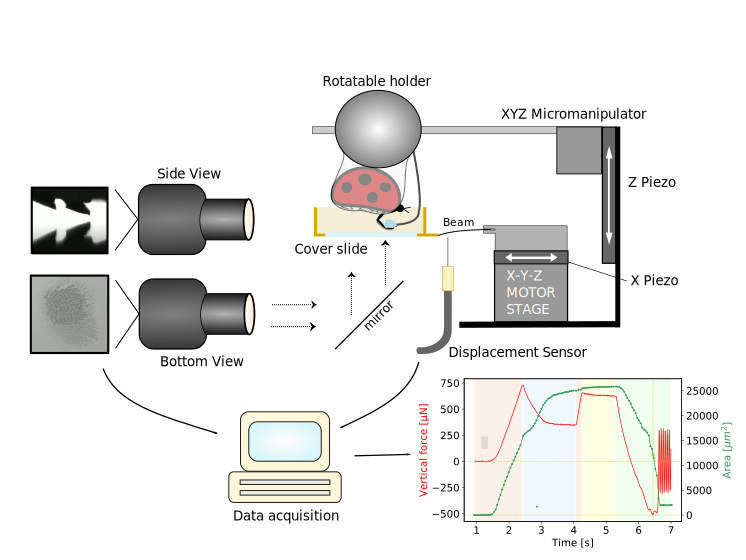

In [16]:
SVG(filename='../source/setup_schematic.svg')

# Figure 2
## Experimental adhesion force results: Effect of substrate and contact type

Load and clean experiment data

In [6]:
# Load experiment data
exptData = pd.read_excel('../Data/experiment_data_all-210105210502.xlsx',
                         engine = 'openpyxl', index_col=0)
exptData = exptData[exptData['Include Data?'] == 'Yes'] #filter out unecessary data
exptData.rename(columns = {'Pulloff Force': 'Adhesion_Force'}, inplace = True)
exptData.rename(columns = {'Contact Type': 'Contact_type'}, inplace = True)
#exptData = exptData[exptData["Contact type"] != "Ambiguous"] #filter out ambiguous data
exptData.replace({'Contact_type': {'Dry': 'In air',
                                   'Bubble': 'Underwater: bubble',
                                   'Wet': 'Underwater: no bubble',
                                   'Ambiguous': 'Underwater: bad contact'}},
                 inplace = True)
exptData['Data'] = 'Experiment'

#average data based on experiment date
group_cols = ['Date of Experiment', 'Contact_type','Substrate','Data']
exptData = exptData.groupby(group_cols).mean().reset_index()

Load and clean model data

In [7]:
# Model data
#folderPath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20201020 ladybug data final/'
dataPath = '../Data/summary_data_ladybug.xlsx'
modelData = pd.read_excel(dataPath, engine = 'openpyxl')
# modelData.rename(columns = {'Model': 'Contact_type'}, inplace = True)
modelData.rename(columns = {'Air': 'In air',
                                   'Underwater: Bubble': 'Underwater: bubble',
                                   'Underwater: Wet': 'Underwater: no bubble'},
                 inplace = True)
column_list = list(modelData.columns)
modelData = modelData[modelData['Hair dia'] == 4e-6] #filter hair diameter (4um)
#force variables in data (used to convert data to long form)
force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
              'Bubble only', 'Underwater: bubble', 'In air', 'Underwater: no bubble']
#forces to include in plot
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']
group_param = ['Contact_type', 'Contact Angle', 'θ-fa', 'θ-fw',
               'D_p/D_h', 'a_b', 'a_f', 'Fluid data file',
               'Bubble data file']

#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Contact_type",
                        value_name="Adhesion_Force")

#filter data to only include relevant forces
data_filtered = data_reshaped[data_reshaped['Contact_type'].
                              isin(force_order)]
#group data (find maxima)
data_grouped = data_filtered.groupby(group_param).min().reset_index()
data_grouped['Adhesion_Force'] *= -1000 #mN to uN convert (+ve convention)
#normalized adhesion calculation
data_grouped['Normalized_Adhesion_Force'] = data_grouped['Adhesion_Force']/\
                                            data_grouped['Hair Area']*1e-12

data_grouped['Substrate'] = np.where(data_grouped['Contact Angle']== 24,
                                     'Glass', 'PFOTS')
data_grouped['Data'] = 'Model'

Organize experimental and model data

In [8]:
exptData_relevant = exptData[['Contact_type',
                              'Adhesion_Force',
                              'Substrate',
                              'Data']].copy()
modelData_relevant = data_grouped[['Contact_type',
                                  'Adhesion_Force',
                                  'Substrate',
                                   'Data']].copy()

modelData_bubbleonly = modelData_relevant[modelData_relevant['Contact_type']=='Bubble only']
modelData_bubbleonly = modelData_bubbleonly.replace({'Contact_type': {'Bubble only': 'Underwater: bubble'}})

modelData_rest = modelData_relevant[modelData_relevant['Contact_type']!='Bubble only']
# dataCombined = exptData_relevant.append(modelData_relevant)

Configure plot style

In [15]:
sns.set(rc={'figure.figsize':(14,12)})
sns.set_theme(context = 'paper',style="ticks",
              palette="Set2", font_scale = 2)
color_list = sns.color_palette('Set2')[1:3]
color_list.reverse()

Plot data

C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\seaborn\categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\seaborn\categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\seaborn\categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


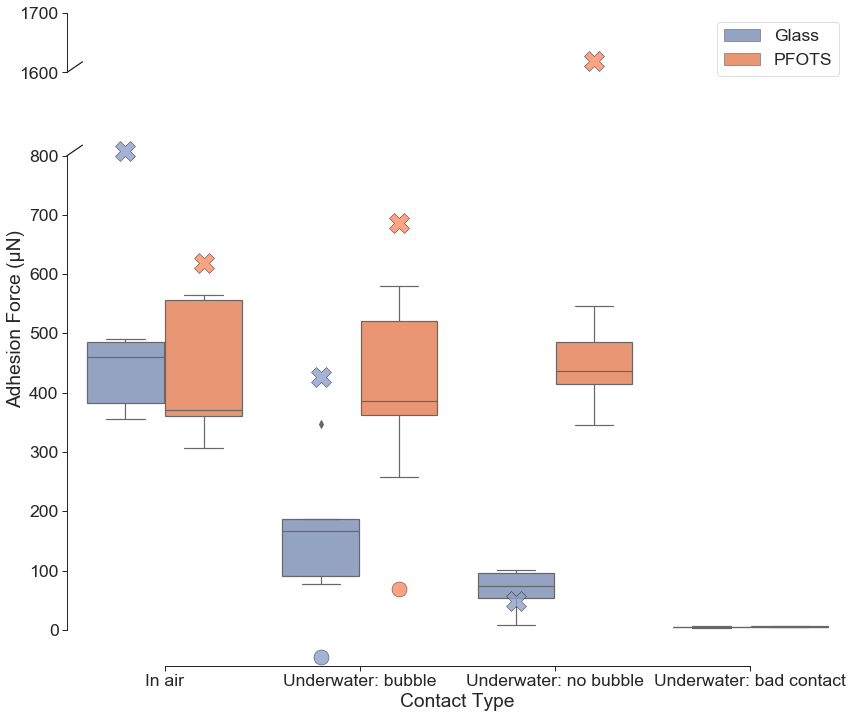

In [22]:
contact_order = ['In air', 'Underwater: bubble', 'Underwater: no bubble', 'Underwater: bad contact']
rc('text', usetex=False)

widths = [1]
heights = [1,9]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
f, (ax_break, ax_main) = plt.subplots(2, 1, sharex=True, gridspec_kw=gs_kw)
#Draw model prediction as stars (for outlier)
ax0 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Glass', 'PFOTS'],
                    dodge = True, marker = 'X', edgecolor = 'k',
                    linewidth=0.5, size = 20, alpha = 0.8,
                data=modelData_rest, ax = ax_break, palette = color_list)
ax0.get_legend().remove()

#Draw model prediction as stars (for main data)
ax1 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Glass', 'PFOTS'],
                    dodge = True, marker = 'X', edgecolor = 'k',
                    linewidth=0.5, size = 20, alpha = 0.8,
                data=modelData_rest, ax = ax_main, palette = color_list)
#define yaxis break condition
ax_break.set_ylim(1600, 1700)  # outliers only
ax_main.set_ylim(-60, 840)  # most of the data
legs1 = ax1.get_legend().texts

#Draw model bubble only prediction as circles
ax15 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Glass', 'PFOTS'],
                    dodge = True, marker = 'o', edgecolor = 'k',
                    linewidth=0.5, size = 15, alpha = 0.8,
                data=modelData_bubbleonly, ax = ax_main, palette = color_list)

#Experimental data plot overlayed
ax2 = sns.boxplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order = contact_order, hue_order = ['Glass', 'PFOTS'],
                data=exptData_relevant, ax = ax_main, palette = color_list)

#clean up legend
handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax_break.legend(handles[0:2], labels[0:2])
ax_main.set_xlabel('Contact Type')
ax_main.set_ylabel('Adhesion Force (μN)', position = (0,0.65))
# ax2.set(xlabel='Contact Type', ylabel='Adhesion Force $[μN]$')

sns.despine(offset=0, trim=True)
# hide the spines between ax and ax2
ax_break.set_xlabel(None)
ax_break.set_ylabel(None)
ax_break.spines['bottom'].set_visible(False)
ax_break.spines['top'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_break.xaxis.set_tick_params(length=0)

#create dashes at axis break
d = .02  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax_break.transAxes, color='k', clip_on=False)
ax_break.plot((0, d), (0, 9*d), **kwargs)        # top-left diagonal

y = 0.955
kwargs.update(transform=ax_main.transAxes)  # switch to the bottom axes
ax_main.plot((0, +d), (y, y + d), **kwargs)  # bottom-left diagonal

plt.show()

Save figure

In [23]:
plot_name = 'Figure5-Expt_Effect_of_contact'

timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax2.get_figure()
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches = 'tight', transparent = True)

Statistical analysis

In [9]:
exptData_filtered = exptData_relevant[exptData_relevant["Contact_type"] != "Underwater: bad contact"]

Test normality of data

In [10]:
norm1 = pg.normality(exptData_filtered[exptData_filtered['Substrate']=='Glass'], 
             dv='Adhesion_Force', group='Contact_type').reset_index()
norm1['Substrate'] = 'Glass'
norm2 = pg.normality(exptData_filtered[exptData_filtered['Substrate']=='PFOTS'], 
             dv='Adhesion_Force', group='Contact_type').reset_index()
norm2['Substrate'] = 'PFOTS'
norm = norm1.append(norm2)
norm

,index,W,pval,normal,Substrate
0,In air,0.855590,0.212842,True,Glass
1,Underwater: no bubble,0.911877,0.478953,True,Glass
2,Underwater: bubble,0.883053,0.323375,True,Glass
0,In air,0.829860,0.138784,True,PFOTS
1,Underwater: bubble,0.956476,0.783257,True,PFOTS
2,Underwater: no bubble,0.994104,0.991910,True,PFOTS


Test equality of variance

In [11]:
var1 = pg.homoscedasticity(exptData_filtered[exptData_filtered['Substrate']=='Glass'], 
             dv='Adhesion_Force', group='Contact_type').reset_index()
var1['Substrate'] = 'Glass'
var2 = pg.homoscedasticity(exptData_filtered[exptData_filtered['Substrate']=='PFOTS'], 
             dv='Adhesion_Force', group='Contact_type').reset_index()
var2['Substrate'] = 'PFOTS'
var = var1.append(var2)
var

,index,W,pval,equal_var,Substrate
0,levene,1.087638,0.368043,True,Glass
0,levene,0.439792,0.654149,True,PFOTS


2 way ANOVA test

In [12]:
pg.anova(data = exptData_filtered,
         dv="Adhesion_Force", 
         between=["Contact_type", "Substrate"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,Contact_type,171500.432,2,85750.216,9.596,0.001,0.444
1,Substrate,323764.479,1,323764.479,36.231,0.000,0.602
2,Contact_type * Substrate,188565.786,2,94282.893,10.551,0.001,0.468
3,Residual,214464.502,24,8936.021,NaN,NaN,NaN


Post-hoc pairwise t-test. CLES is the proportion of pairs where A is higher than B

In [15]:
t_test1 = pg.pairwise_ttests(data = exptData_filtered,
                           dv="Adhesion_Force",
                           between=["Contact_type", "Substrate"],
                           effsize = 'CLES',
                           padjust = 'bonf',
                           interaction=True,
                           parametric = True).round(3)
t_test1.rename(columns = {'Contact_type': 'Fixed variable'}, inplace=True)
t_test2 = pg.pairwise_ttests(data = exptData_filtered,
                           dv="Adhesion_Force",
                           between=["Substrate", "Contact_type"],
                           effsize = 'CLES',
                           padjust = 'bonf',
                           interaction=True,
                           parametric = True).round(3)
t_test2.rename(columns = {'Substrate': 'Fixed variable'}, inplace=True)
t_test = t_test1.append(t_test2)
t_test.query('`Fixed variable`!="-"')

,Contrast,Fixed variable,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,CLES
4,Contact_type * Substrate,In air,PFOTS,Glass,False,True,-0.053,8.0,two-sided,0.959,1.000,bonf,0.493,0.48
5,Contact_type * Substrate,Underwater: bubble,PFOTS,Glass,False,True,3.292,8.0,two-sided,0.011,0.033,bonf,4.893,0.96
6,Contact_type * Substrate,Underwater: no bubble,PFOTS,Glass,False,True,10.044,8.0,two-sided,0.000,0.000,bonf,1316.152,1.00
4,Substrate * Contact_type,PFOTS,In air,Underwater: bubble,False,True,0.133,8.0,two-sided,0.897,1.000,bonf,0.495,0.48
5,Substrate * Contact_type,PFOTS,In air,Underwater: no bubble,False,True,-0.224,8.0,two-sided,0.828,1.000,bonf,0.5,0.48
6,Substrate * Contact_type,PFOTS,Underwater: bubble,Underwater: no bubble,False,True,-0.370,8.0,two-sided,0.721,1.000,bonf,0.514,0.44
7,Substrate * Contact_type,Glass,In air,Underwater: bubble,False,True,4.688,8.0,two-sided,0.002,0.009,bonf,19.504,1.00
8,Substrate * Contact_type,Glass,In air,Underwater: no bubble,False,True,11.341,8.0,two-sided,0.000,0.000,bonf,2847.34,1.00
9,Substrate * Contact_type,Glass,Underwater: bubble,Underwater: no bubble,False,True,2.086,8.0,two-sided,0.070,0.423,bonf,1.52,0.84


Save t-test results

In [14]:
t_test_clean = t_test[t_test['Fixed variable'] != '-'].reset_index(drop=True)
t_test_clean.drop(columns=['Contrast', 'Paired', 'Parametric', 'dof', 'Tail', 'BF10'],
                      inplace=True)
t_test_clean.to_csv('../Data/stats_table.csv', index=False)

# Figure 3
## Capillary Bridge Model schematic

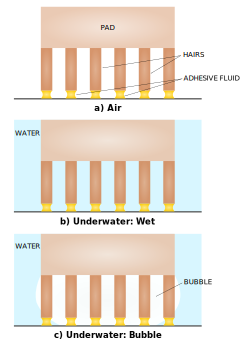

In [4]:
SVG("../source/model_schematic.svg")

# Figure 4
## Capillary force of a single pinned liquid bridge

Import single bridge data

In [191]:
# folderPath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20201006 model data final (af=2, l_d=10)/'
dataPath = '../Data/fluid_bridge_data.xlsx'

modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset


### a. Force-distance curves

Clean data

In [26]:
model_data_fd = modelData.copy()
model_data_fd.rename(columns={'Bottom_Angle': 'Contact Angle'}, inplace = True)
#forces scale
model_data_fd['Force'] *= 2*np.pi
model_data_fd['Force_Calc'] *= 2*np.pi

#include degree sign to contact angle
model_data_fd['Contact Angle'] = model_data_fd['Contact Angle'].astype(str) + '°'

Configure plot style

In [27]:
sns.set_theme(context = 'talk',
              style="ticks",
              palette = sns.color_palette("hls", 7))
fig_size = (7,6) #figure size

Plot data

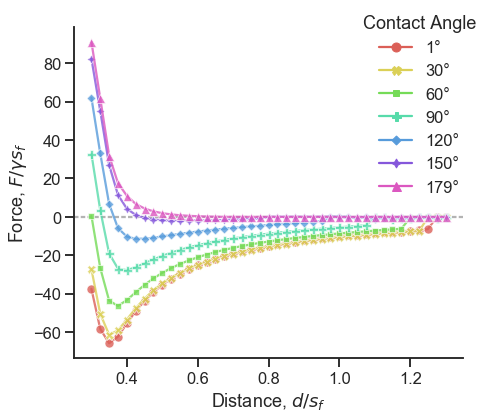

In [30]:
# x_label = "Distance, d/s"
# y_label = r"Force, $F/\gamma s$"
angle_order = ['1°','30°','60°','90°','120°','150°', '179°']
rc('text', usetex=False)

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=model_data_fd,
                 x = "Height",
                 y = "Force_Calc",
                 hue = "Contact Angle",
                 hue_order = angle_order,
                 style = "Contact Angle",
                 style_order = angle_order,
                 kind = 'line',
                 markers = True,
                 dashes = False,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

#format plot
ax.fig.set_size_inches(*fig_size)
(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels("Distance, $d/s_f$", r"Force, $F/\gamma s_f$")
  .tight_layout(w_pad=0))
##if zero_line == True:
##    ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)

#rename legend text based on latex_map 
# for text in ax._legend.texts:
#     if text.get_text() in latex_map.keys():
#         text.set_text('$' + latex_map[text.get_text()] + '$')

##ax.set_axis_labels(x_label, y_label)
leg = ax._legend
leg._loc = 1 #legend position
##leg.set_bbox_to_anchor([1,0.75])
##
##ax.tight_layout(w_pad=0)


ax.fig.tight_layout()

##sns.despine(offset=10, trim=True)

plt.show()


Save figure

In [31]:
plot_name = "Figure1-Single_bridge"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

### b. Force contributions

Clean data

In [192]:
model_data_cnt = modelData.copy()

model_data_cnt.rename(columns={'Force': 'Force Deriv'}, inplace = True) #force from energy derivative
model_data_cnt.rename(columns={'Force_Calc': 'Total'}, inplace = True) #force from energy derivative

#forces scale
model_data_cnt['Force Deriv'] *= 2*np.pi
model_data_cnt['Total'] *= 2*np.pi
model_data_cnt['Laplace'] = (model_data_cnt['Pressure'] - model_data_cnt['Ambient_Pressure']) * model_data_cnt['Bottom_Area']
model_data_cnt['Surface Tension'] = -1 * model_data_cnt['Bottom_Length'] * np.sin(model_data_cnt['Bottom_Angle']*np.pi/180)
##modelData['Force_Total'] = modelData['Force_Laplace'] + modelData['Force_Surface_Tension']

column_list = list(model_data_cnt.columns)

#group data based on these columns
group_vars = ['Bottom_Angle', 'Pin_Radius', 'Elastic_Modulus', 'Aspect_Ratio',
              'Ambient_Pressure']
#force variables in data (used to convert data to long form)
force_vars = ['Force Deriv', 'Total', 'Laplace',
              'Surface Tension']
#forces to include in plot
force_order = ['Total', 'Laplace', 'Surface Tension']


#find minimum force based on Force_Calce and its corresponding values
model_data_cnt = model_data_cnt.loc[model_data_cnt.groupby(group_vars)["Total"].idxmin()]

#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
model_data_cnt = pd.melt(model_data_cnt,
                        id_vars = id_vars_list,
                        var_name="Force",
                        value_name="Force value")

#filter data
model_data_cnt = model_data_cnt[model_data_cnt['Force'].
                              isin(force_order)]




Configure plot style

In [193]:
sns.set_theme(context = 'talk',
              style="ticks",
              palette = sns.color_palette("hls", 7))
fig_size = (7,6) #figure size
plot_name = "Figure1-Force_contribution"

Plot data

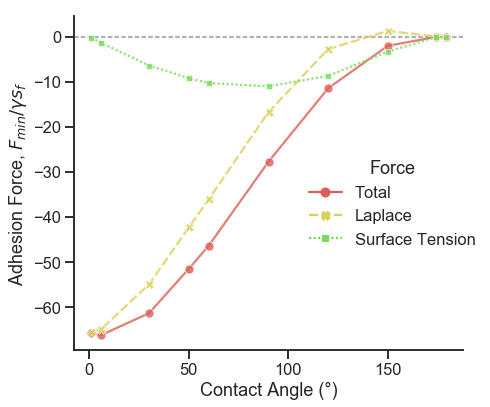

In [194]:
rc('text', usetex=False)

ax = sns.relplot(data=model_data_cnt,
                 x = "Bottom_Angle",
                 y = "Force value",
                 hue = "Force",
                 hue_order = None,
                 style = "Force",
                 style_order = None,
                 kind = 'line',
                 markers = True,
                 alpha = 0.8)

#format plot
ax.fig.set_size_inches(*fig_size)
(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels("Contact Angle (°)", r"Adhesion Force, $F_{min}/\gamma s_f$")
  .tight_layout(w_pad=0))

ax.fig.tight_layout()

plt.show()

Save figure

In [195]:
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name +"-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

# Figure 5
## Capillary Bridge Model: Effect of Substrate

Import data

In [109]:
dataPath = '../Data/summary_data-effect of hair size_v2.xlsx'

modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset

Clean data

In [110]:
modelData.rename(columns = {'Air': 'In air',
                                   'Underwater: Bubble': 'Underwater: bubble',
                                   'Underwater: Wet': 'Underwater: no bubble'},
                 inplace = True)
column_list = list(modelData.columns)

#force variables in data (used to convert data to long form)
force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
              'Bubble only', 'Underwater: bubble', 'In air', 'Underwater: no bubble']
#forces to include in plot
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']

fixed_param = {'D_p/D_h' : [50],
               'a_b' : [1.5]} #fixed parameters in order of textbox display

#include degree sign to contact angle
modelData['Contact Angle'] = modelData['Contact Angle'].astype(str) + '°'

#filter data based on fixed parameters
for param in fixed_param.keys():
    modelData = modelData[modelData[param].isin(fixed_param[param])]

#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Model",
                        value_name="Force")

#filter data
data_filtered = data_reshaped[data_reshaped['Model'].
                              isin(force_order)]

data_grouped = data_filtered

#create latex formatted mapping for relevant column names for plot display
#change this to alter displayed parameter text
latex_map = {'D_p/D_h' : r'D_p/D_h',
             'a_b' : r'\phi_b',
            'V_b' : r'\hat{V}_b'}
#set volume as fixed instead of phi_b
latex_fix_param = {'D_p/D_h' : [50],
                   'V_b' : ["{:.1e}".format(modelData['Vb'].iloc[0]).replace('+0', '')]}
#textbox text in latex format
fixed_param_text = r' \\ '.join([latex_map[x] + '&=&' +
                                 ','.join(map(str,latex_fix_param[x]))
                              for x in latex_fix_param.keys()])

Configure plot style

In [111]:
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (12,6) #figure size

Plot data

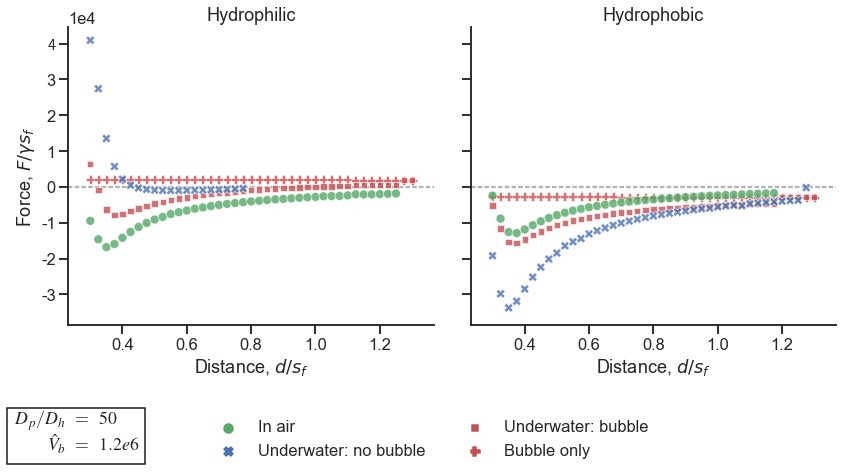

In [112]:
color_list = ['g', 'b', 'r', 'r'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted
rc('text', usetex=False)

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_grouped,
                 x = "Distance",
                 y = "Force",
                 hue = "Model",
                 hue_order = force_order,
                 style = "Model",
                 style_order = force_order,
                 col = "Contact Angle",
                 col_order = ['24°','120°'],
                 palette= color_list,
                 kind = 'scatter',
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels("Distance, $d/s_f$", r"Force, $F/\gamma s_f$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
for ax1 in ax.axes.flatten():
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
#legend adjust
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = 2,
                 framealpha = 0)
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds
##w = w/col_num
##h = h/col_num
bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 8 #legend location

#draw textbox of fixed parameters (UNCOMMENT THIS)
rc('font',**{'serif':['Times']})
rc('text', usetex=True)

text = r"\begin{eqnarray*}" + fixed_param_text + r"\end{eqnarray*}"
anc = AnchoredText(text, loc="lower left", frameon=True,
                   bbox_to_anchor= (0,-h),
                   bbox_transform=ax.fig.transFigure)
##anc.patch.set_alpha(0)
##anc.patch.set_edgecolor('k')
ax.fig.add_artist(anc)

#format plot
ax.fig.set_size_inches(*fig_size)

#replace titles in order left to right
titles = ['Hydrophilic', 'Hydrophobic']
axes = ax.axes.flatten()
for i, ax1 in enumerate(axes):
    ax1.set_title(titles[i])
    
plt.show()



Save figure

In [113]:
plot_name = "Figure2-Effect_of_substrate"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)


C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (68) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (112) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (104) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplo

# Figure 6
## Capillary Bridge Model: Effect of hair diameter

Import data

In [127]:
dataPath = '../Data/summary_data-effect of hair size_v2.xlsx'

modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset

Data clean

In [128]:
modelData.rename(columns = {'Air': 'In air',
                                   'Underwater: Bubble': 'Underwater: bubble',
                                   'Underwater: Wet': 'Underwater: no bubble'},
                 inplace = True)
column_list = list(modelData.columns)

#force variables in data (used to convert data to long form)
force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
              'Bubble only', 'Underwater: bubble', 'In air', 'Underwater: no bubble']
#forces to include in plot
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']#['Air','Underwater: Wet','Underwater: Bubble','Bubble only']

group_param = ['Model', 'Contact Angle', 'θ-fa', 'θ-fw',
               'D_p/D_h', 'a_b', 'a_f', 'Fluid data file',
               'Bubble data file'] 
fixed_param = {'Pad dia': [200],
               'a_b' : [1.5]} #fixed parameters in order of textbox display

#include degree sign to contact angle
modelData['Contact Angle'] = modelData['Contact Angle'].astype(str) + '°'

#filter data based on fixed parameters
# for param in fixed_param.keys():
#     modelData = modelData[modelData[param].isin(fixed_param[param])]

#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Model",
                        value_name="Force")

#filter data
data_filtered = data_reshaped[data_reshaped['Model'].
                              isin(force_order)]

#group data (find maxima)
data_grouped = data_filtered.groupby(group_param).min().reset_index()

#normalize w.r.t pad dia
# data_grouped['Force'] = data_grouped['Force']/data_grouped['Pad dia']
# data_grouped['Hair dia'] = data_grouped['Hair dia']/data_grouped['Pad dia']

#create latex formatted mapping for relevant column names for plot display
#change this to alter displayed parameter text
latex_map = {'D_p/D_h' : r'D_p/D_h',
             'a_b' : r'\phi_b',
            'V_b' : r'V_b',
            'Pad dia': r'D_p'}
#set volume as fixed instead of phi_b
latex_fix_param = {'Pad dia': [200],
                   'V_b' : ["{:.1e}".format(modelData['Vb'].iloc[0]).replace('+0', '')]}
#textbox text in latex format
fixed_param_text = r' \\ '.join([latex_map[x] + '&=&' +
                                 ','.join(map(str,latex_fix_param[x]))
                              for x in latex_fix_param.keys()])

Configure plot style

In [129]:
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (11,6) #figure size

Plot data

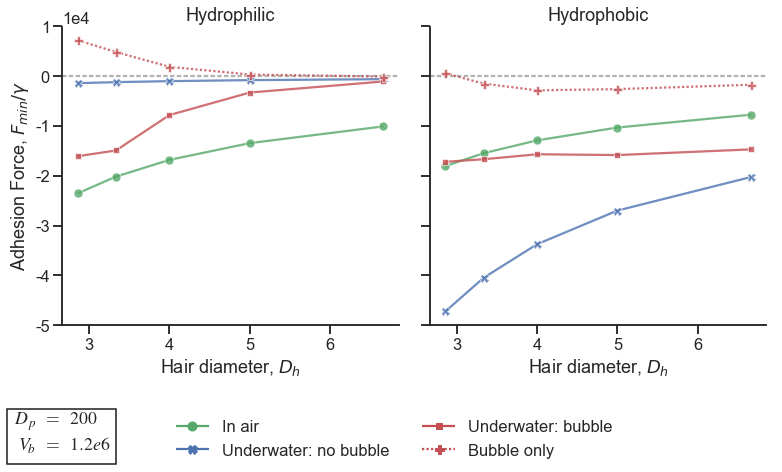

In [130]:
color_list = ['g', 'b', 'r', 'r']#['g', 'b', 'r', 'c'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)]#[(1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted
rc('text', usetex=False)

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_grouped,
                 x = "Hair dia",
                 y = "Force",
                 hue = "Model",
                 hue_order = force_order,
                 style = "Model",
                 style_order = force_order,
                 col = "Contact Angle",
                 col_order = ['24°','120°'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels(r'Hair diameter, $D_h$', 
                      r"Adhesion Force, $F_{min}/\gamma$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
for ax1 in ax.axes.flatten():
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
#legend adjust
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = 2,
                 framealpha = 0)
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds
bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 8 #legend location

#draw textbox of fixed parameters UNCOMMENT THIS
rc('font',**{'serif':['Times']})
rc('text', usetex=True)

text = r"\begin{eqnarray*}" + fixed_param_text + r"\end{eqnarray*}"
anc = AnchoredText(text, loc="lower left", frameon=True,
                   bbox_to_anchor= (0,-h),
                   bbox_transform=ax.fig.transFigure)
##anc.patch.set_alpha(0)
##anc.patch.set_edgecolor('k')
ax.fig.add_artist(anc)

#format plot
ax.fig.set_size_inches(*fig_size)

#replace titles in order left to right
titles = ['Hydrophilic', 'Hydrophobic']
axes = ax.axes.flatten()
for i, ax1 in enumerate(axes):
    ax1.set_title(titles[i])

plt.show()


Save figure

In [131]:
plot_name = "Figure3-Effect_of_hair_size"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (68) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (112) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (50) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotl

# Figure 7
## Capillary Bridge Model: Effect of bubble volume

Import data

In [159]:
dataPath = '../Data/summary_data_final.xlsx' #CHECK THIS

modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset

Data clean

In [160]:
# modelData.rename(columns = {'Air': 'In air',
#                                    'Underwater: Bubble': 'Underwater: bubble',
#                                    'Underwater: Wet': 'Underwater: no bubble'},
#                  inplace = True)


#force variables in data (used to convert data to long form)
force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
              'Bubble only', 'Underwater: Bubble', 'Air', 'Underwater: Wet']
#forces to include in plot
force_order = ['Underwater: Bubble', 'Bubble only']#['Air','Underwater: Wet','Underwater: Bubble','Bubble only']

group_param = ['Contact Type', 'Contact Angle', 'Surface', 'θ-fa', 'θ-fw',
               'D_p/D_h', 'a_b', 'a_f', 'Fluid data file',
               'Bubble data file'] 
fixed_param = {'D_p/D_h' : [50]} #fixed parameters in order of textbox display
#create latex formatted mapping for relevant column names for plot display
#change this to alter displayed parameter text
latex_map = {'D_p/D_h' : r'D_p/D_h',
             'a_b' : r'\phi_b'}
##latex_map = {'D_p/D_h' : r'\frac{D_p}{D_h}',
##             'a_b' : r'\phi_b'} 


#textbox text in latex format
fixed_param_text = r' \\ '.join([latex_map[x] + '&=&' +
                                 ','.join(map(str,fixed_param[x]))
                              for x in fixed_param.keys()])


#include degree sign to contact angle
# modelData['Contact Angle'] = modelData['Contact Angle'].astype(str) + '°'
#type of surface
modelData['Surface'] = modelData['Contact Angle'].map({24:'Hydrophilic', 
                                                       120:'Hydrophobic'})

#filter data based on fixed parameters
for param in fixed_param.keys():
    modelData = modelData[modelData[param].isin(fixed_param[param])]

column_list = list(modelData.columns)
#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Contact Type",
                        value_name="Force")

#filter data
data_filtered = data_reshaped[data_reshaped['Contact Type'].
                              isin(force_order)]


#group data (find maxima)
data_grouped = data_filtered.groupby(group_param).min().reset_index()


Configure plot style

In [161]:
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (7.5,6) #figure size

Plot data

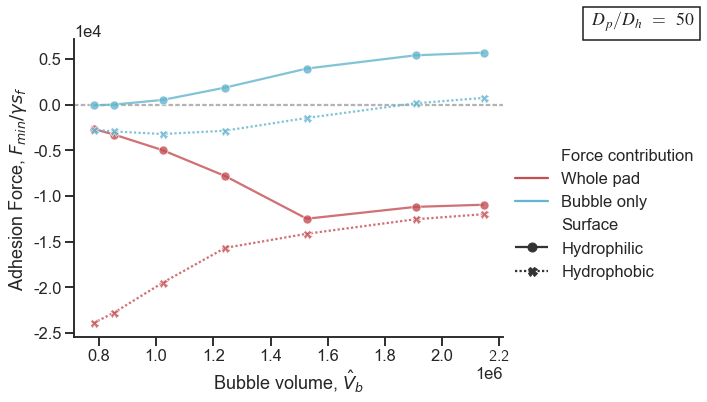

In [162]:
color_list = ['r', 'c'] #corresponding colors
line_styles = [(1, 0),(1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted
rc('text', usetex=False)

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_grouped,
                 x = "Vb",
                 y = "Force",
                 hue = "Contact Type",
                 hue_order = force_order,
                 style = "Surface",
                 style_order = ['Hydrophilic','Hydrophobic'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels(r'Bubble volume, $\hat{V}_b$', 
                      r"Adhesion Force, $F_{min}/\gamma s_f$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
for ax1 in ax.axes.flatten():
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    
#legend adjust
col_num = 1 #number of legend columns SET
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = col_num,
                 framealpha = 0)

legend_map = {'Contact Type': 'Force contribution',
              'Underwater: Bubble': 'Whole pad'}
#rename legend text based on latex_map 
for text in leg.texts:
    if text.get_text() in latex_map.keys():
        text.set_text('$' + latex_map[text.get_text()] + '$')
    if text.get_text() in legend_map.keys():
        text.set_text(legend_map[text.get_text()])
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds

bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 7 #legend location SET

#draw textbox of fixed parameters UNCOMMENT THIS
rc('font',**{'serif':['Times']})
rc('text', usetex=True)

##r"\frac{D}{d}&=&50\\ \phi_b&=&0.5"
text = r"\begin{eqnarray*}" + fixed_param_text + r"\end{eqnarray*}"
anc = AnchoredText(text, loc="upper right", frameon=True,
                   bbox_to_anchor= (1+w, 1),
                   bbox_transform=ax.fig.transFigure)
##anc.patch.set_alpha(0)
##anc.patch.set_edgecolor('k')
ax.fig.add_artist(anc)

#format plot
ax.fig.set_size_inches(*fig_size)


plt.show()

Save figure

In [163]:
plot_name = "Figure4-Effect_of_bubble_volume"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (68) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (112) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (104) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplo

# Figure 8
## Predictions for gecko adhesion

Import data

In [181]:
# Load experiment data
geckoData = pd.read_excel('../Data/gecko_comparison.xlsx', engine = 'openpyxl')

#filter based on substrates
# geckoData = geckoData[(geckoData['Substrate'] == 'Glass') | True]#(geckoData['Substrate'] == 'PTFE')]

Configure plot style

In [182]:
sns.set_theme(context = 'paper',style="ticks",
              font_scale = 2)
fig_size = (11,5) #figure size

#only 2 colors chosen
color_list = sns.color_palette('Set2')[1:3] #['lightgreen', 'b']
# color_list.reverse() #reversed so blue is for Wet

Plot data

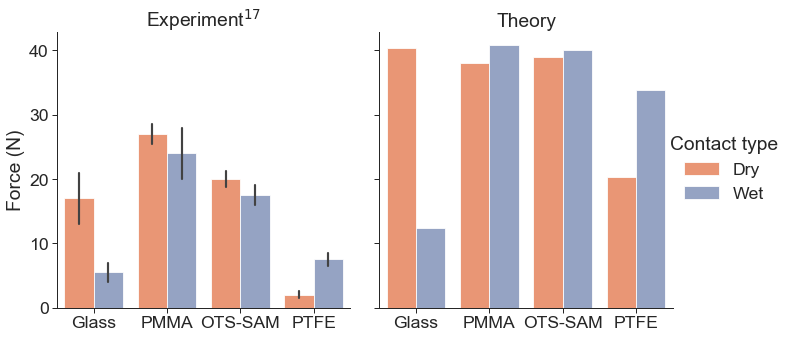

In [183]:
rc('text', usetex=False)
# Draw a nested boxplot to show bills by day and time
ax = sns.catplot(x='Substrate', y='Force',
                 order = ['Glass', 'PMMA', 'OTS-SAM', 'PTFE'],
                hue='Contact type', col = 'Source',
                 col_order = ['Reference', 'Model'],
                kind = 'bar', data=geckoData,
                 palette = color_list)

# ax.set(xlabel=None, ylabel='Force (N)')
ax.axes[0][0].set_ylabel('Force (N)')
ax.axes[0][0].set_xlabel('')
ax.axes[0][1].set_xlabel('')
#replace 'Source = ' from titles
titles = ['Experiment$^{17}$', 'Theory']
axes = ax.axes.flatten()
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
#     ax.set_title(ax.get_title().replace('Source = ', ''))

    
#format plot
ax.figure.set_size_inches(*fig_size)

plt.show()

Save figure

In [184]:
plot_name = 'Figure-9-Gecko_comparison'
fig = ax.figure
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches = 'tight', transparent = True)

# Figure S1
## Single fluid bridge: Effect of fluid volume

Import data

In [196]:
dataPath = '../Data/fluid_data_all.xlsx'
modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset

Clean data

In [197]:
modelData.rename(columns={'Force': 'Force Deriv'}, inplace = True) #force from energy derivative
modelData.rename(columns={'Force_Calc': 'Total'}, inplace = True) #force from energy derivative
#include degree sign to contact angle
##modelData['Contact Angle'] = modelData['Bottom_Angle'].astype(str) + '°'

modelData['Contact Angle'] = (180-modelData['Bottom_Angle']).astype(str) + '°'
#non dimensionalize volume, length scale relative to pinned DIAMETER (factor of 2)
modelData['Fluid Volume'] = (4*np.pi/3)*((modelData['Pin_Radius']*2)**(-3))

#forces scale
modelData['Force Deriv'] *= 2*np.pi*modelData['Pin_Radius']*2
modelData['Total'] *= 2*np.pi*modelData['Pin_Radius']*2
modelData['Laplace'] = (modelData['Pressure'] - modelData['Ambient_Pressure']) * modelData['Bottom_Area']*modelData['Pin_Radius']*2
modelData['Surface Tension'] = -1 * modelData['Bottom_Length'] * np.sin(modelData['Bottom_Angle']*np.pi/180)*modelData['Pin_Radius']*2
##modelData['Force_Total'] = modelData['Force_Laplace'] + modelData['Force_Surface_Tension']

column_list = list(modelData.columns)

#group data based on these columns
group_vars = ['Bottom_Angle', 'Pin_Radius', 'Elastic_Modulus', 'Aspect_Ratio',
              'Ambient_Pressure']

modelData = modelData.loc[modelData.groupby(group_vars)["Total"].idxmin()]

Configure plot style

In [198]:
sns.set_theme(context = 'talk',
              style="ticks",
              palette = sns.color_palette("hls", 4))
fig_size = (7,6) #figure size

Plot data

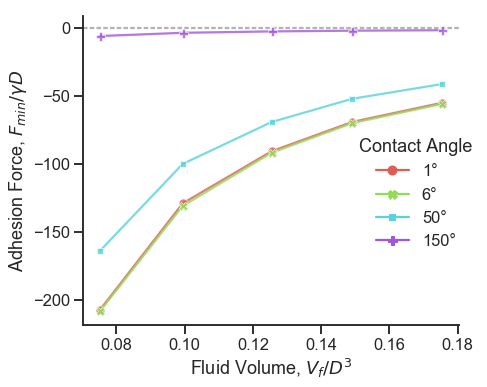

In [199]:
angle_order = ['1°','6°','50°','150°']
rc('text', usetex=False)

ax = sns.relplot(data=modelData,
                 x = "Fluid Volume",
                 y = "Total",
                 hue = "Contact Angle",
                 hue_order = angle_order,
                 style = "Contact Angle",
                 style_order = angle_order,
                 kind = 'line',
                 markers = True,
                 dashes = False,
                 alpha = 0.8)

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels("Fluid Volume, $V_f/D^3$", r"Adhesion Force, $F_{min}/\gamma D$")
  .tight_layout(w_pad=0))

fig = ax.fig

fig.tight_layout()

#format plot
ax.fig.set_size_inches(*fig_size)

plt.show()

Save figure

In [200]:
plot_name = "FigureS1-Effect_of_fluid_volume"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

# Figure S2
## Capillary Bridge Model: Effect of hair diameter (constant total fluid)

Import data

In [185]:
dataPath = '../Data/summary_data_constant_vol.xlsx'

modelData = pd.read_excel(dataPath, engine = 'openpyxl') # Load dataset

Data clean

In [186]:
modelData.rename(columns = {'Air': 'In air',
                                   'Underwater: Bubble': 'Underwater: bubble',
                                   'Underwater: Wet': 'Underwater: no bubble'},
                 inplace = True)
column_list = list(modelData.columns)

#force variables in data (used to convert data to long form)
force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
              'Bubble only', 'Underwater: bubble', 'In air', 'Underwater: no bubble']
#forces to include in plot
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']#['Air','Underwater: Wet','Underwater: Bubble','Bubble only']

group_param = ['Model', 'Contact Angle', 'θ-fa', 'θ-fw',
               'D_p/D_h', 'a_b', 'a_f', 'Fluid data file',
               'Bubble data file'] 
fixed_param = {'a_b' : [1.5],
              'Pad dia': [200]} #fixed parameters in order of textbox display

#include degree sign to contact angle
modelData['Contact Angle'] = modelData['Contact Angle'].astype(str) + '°'

#filter data based on fixed parameters
# for param in fixed_param.keys():
#     modelData = modelData[modelData[param].isin(fixed_param[param])]

#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_vars]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Model",
                        value_name="Force")

#filter data
data_filtered = data_reshaped[data_reshaped['Model'].
                              isin(force_order)]

#group data (find maxima)
data_grouped = data_filtered.groupby(group_param).min().reset_index()

#normalize w.r.t pad dia
# data_grouped['Force'] = data_grouped['Force']/data_grouped['Pad dia']
# data_grouped['Hair dia'] = data_grouped['Hair dia']/data_grouped['Pad dia']
#create latex formatted mapping for relevant column names for plot display
#change this to alter displayed parameter text
latex_map = {'D_p/D_h' : r'D_p/D_h',
             'a_b' : r'\phi_b',
            'V_b' : r'V_b',
            'Pad dia': r'D_p'}
#set volume as fixed instead of phi_b
latex_fix_param = {'Pad dia': [200],
                   'V_b' : ["{:.1e}".format(modelData['Vb'].iloc[0]).replace('+0', '')]}
#textbox text in latex format
fixed_param_text = r' \\ '.join([latex_map[x] + '&=&' +
                                 ','.join(map(str,latex_fix_param[x]))
                              for x in latex_fix_param.keys()])

Configure plot style

In [187]:
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (11,6) #figure size

Plot data

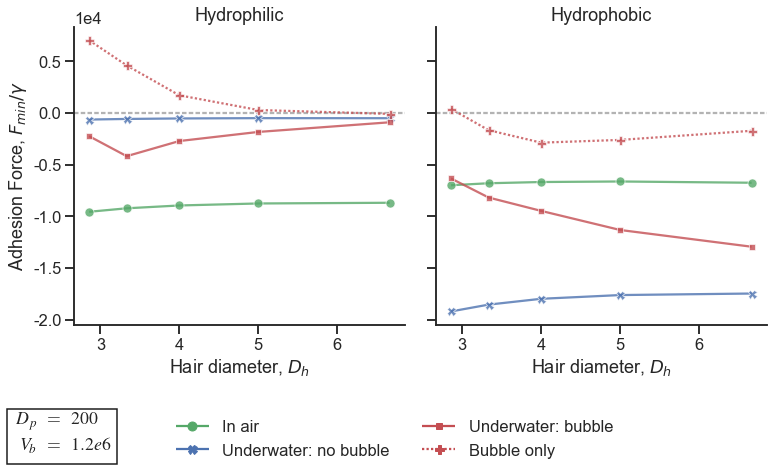

In [189]:
color_list = ['g', 'b', 'r', 'r']#['g', 'b', 'r', 'c'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)]#[(1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted
rc('text', usetex=False)

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_grouped,
                 x = "Hair dia",
                 y = "Force",
                 hue = "Model",
                 hue_order = force_order,
                 style = "Model",
                 style_order = force_order,
                 col = "Contact Angle",
                 col_order = ['24°','120°'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
     .set_axis_labels(r'Hair diameter, $D_h$', 
                      r"Adhesion Force, $F_{min}/\gamma$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
for ax1 in ax.axes.flatten():
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
#legend adjust
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = 2,
                 framealpha = 0)
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds
bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 8 #legend location

#draw textbox of fixed parameters UNCOMMENT THIS
rc('font',**{'serif':['Times']})
rc('text', usetex=True)

text = r"\begin{eqnarray*}" + fixed_param_text + r"\end{eqnarray*}"
anc = AnchoredText(text, loc="lower left", frameon=True,
                   bbox_to_anchor= (0,-h),
                   bbox_transform=ax.fig.transFigure)
##anc.patch.set_alpha(0)
##anc.patch.set_edgecolor('k')
ax.fig.add_artist(anc)

#format plot
ax.fig.set_size_inches(*fig_size)

#replace titles in order left to right
titles = ['Hydrophilic', 'Hydrophobic']
axes = ax.axes.flatten()
for i, ax1 in enumerate(axes):
    ax1.set_title(titles[i])

plt.show()


Save figure

In [190]:
plot_name = "FigureS2-Effect_of_hair_size(constant_vol)"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (68) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (112) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (50) of font (C:/Users/adwait/AppData/Local/Programs/MiKTeX/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\Users\adwait\Desktop\Python\Buggee\environment\lib\site-packages\matplotl